In [1]:
# copy template to $(jupyter --data-dir)/nbextensions/snippets/snippets.json

from logging import basicConfig
from pathlib import Path
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

from IPython.core.display import HTML
from IPython.display import display, clear_output

warnings.filterwarnings('ignore')

display(
    HTML("""
          <style type="text/css">
          table.dataframe td, table.dataframe th {
              border: 1px  black solid !important;
              color: black !important;
          }
          </style>
         <style>.container { width:100% !important; }</style>
         """))

plt.rcParams['figure.figsize'] = (15, 7)
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 100
sns.set()

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.options.display.precision = 3

np.set_printoptions(precision=3, linewidth=200, suppress=True)

basicConfig(level='INFO',
            format='%(asctime)s %(levelname)s %(message)s',
            datefmt='%d/%m/%Y %H:%M:%S%z')
LOGGER = getLogger(__name__)

CACHE = {}

#  RandomSeed Set

In [2]:
import random

In [3]:
np.random.seed(1337)
random.seed(1337)

# Data Creation

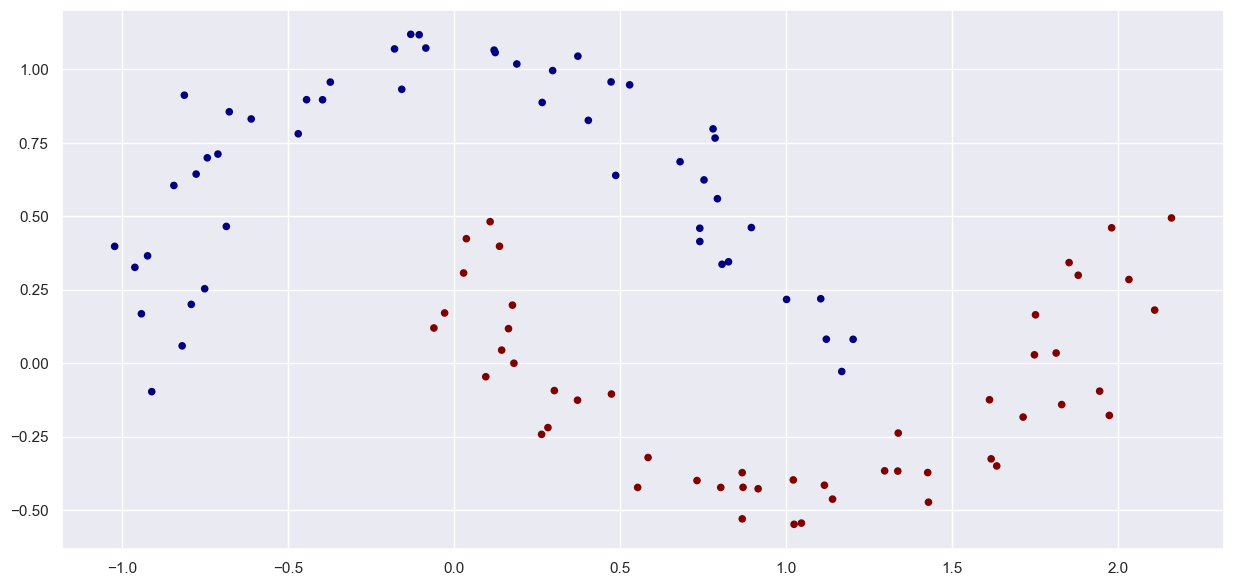

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

# Implemented MLP

In [5]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [6]:
# initialize a model
model = MLP(2, [8, 8, 1],)  # 2-layer neural network
print(model)
print("number of parameters: ", len(model.parameters))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8)], Layer of [LinearNeuron(8)]]
number of parameters:  105


In [7]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = Xb

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum(p * p for p in model.parameters)
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0)
                for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.7456690791160169, grad=0) 0.69


In [8]:
losses = []
accuracies = []

for epoch in range(101):
    # forward
    total_loss, acc = loss()
    losses.append(total_loss.data)
    accuracies.append(acc)
    
    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9 * epoch / 100
    for p in model.parameters:
        p.data -= learning_rate * p.grad

    if epoch % 5 == 0:
        print(f"step {epoch} loss {round(total_loss.data, pd.options.display.precision)}, accuracy {acc * 100}%")

step 0 loss 0.746, accuracy 69.0%
step 5 loss 0.365, accuracy 81.0%
step 10 loss 0.337, accuracy 85.0%
step 15 loss 0.297, accuracy 86.0%
step 20 loss 0.269, accuracy 88.0%
step 25 loss 0.252, accuracy 91.0%
step 30 loss 0.243, accuracy 89.0%
step 35 loss 0.227, accuracy 91.0%
step 40 loss 0.209, accuracy 91.0%
step 45 loss 0.188, accuracy 91.0%
step 50 loss 0.17, accuracy 92.0%
step 55 loss 0.149, accuracy 94.0%
step 60 loss 0.117, accuracy 94.0%
step 65 loss 0.115, accuracy 96.0%
step 70 loss 0.091, accuracy 96.0%
step 75 loss 0.072, accuracy 99.0%
step 80 loss 0.044, accuracy 100.0%
step 85 loss 0.042, accuracy 100.0%
step 90 loss 0.032, accuracy 100.0%
step 95 loss 0.024, accuracy 100.0%
step 100 loss 0.023, accuracy 100.0%


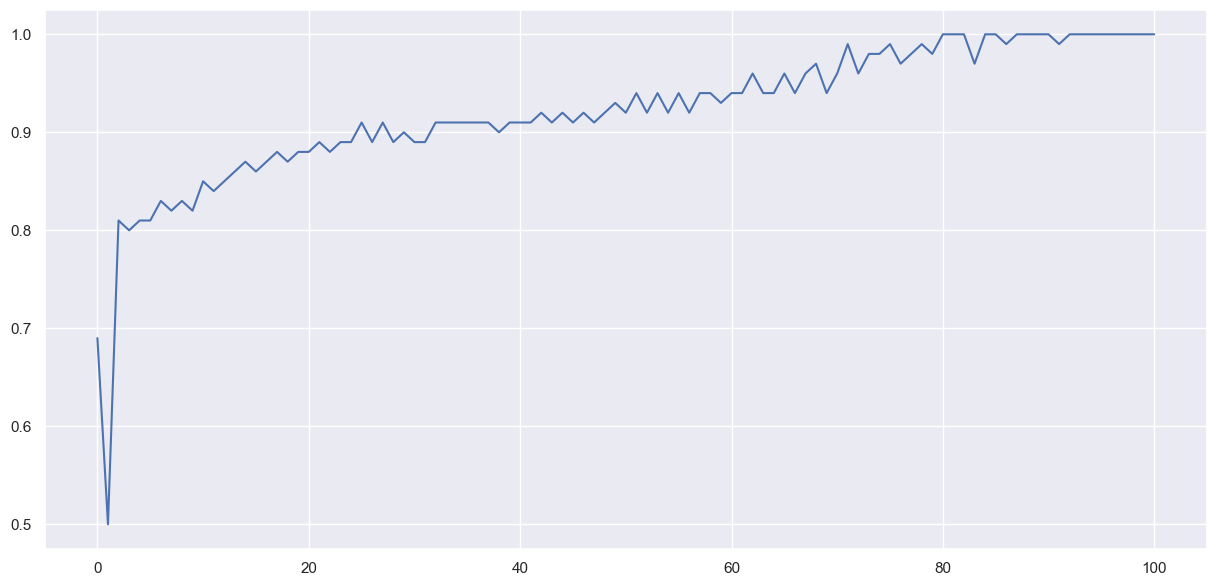

In [9]:
plt.plot(accuracies)

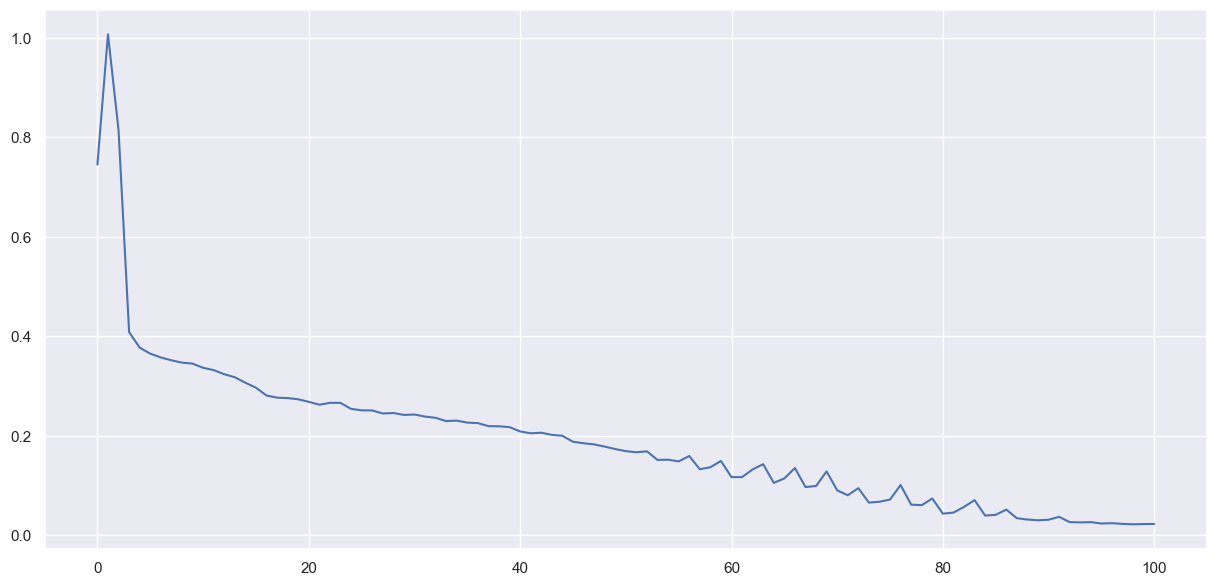

In [10]:
plt.plot(losses)

(-1.548639298268643, 1.951360701731357)

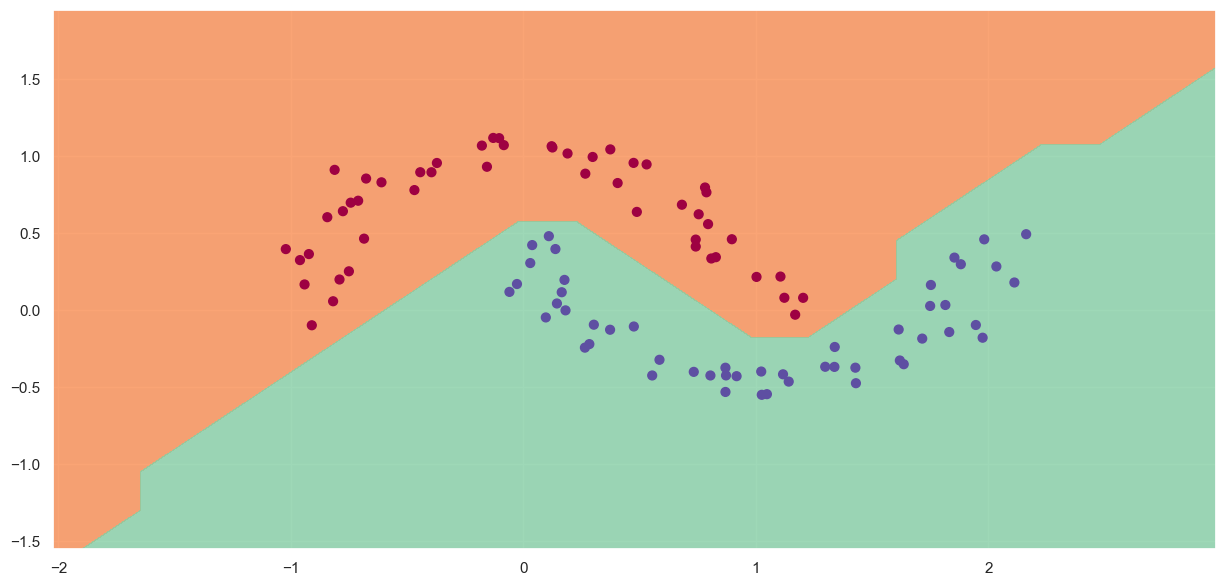

In [11]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = Xmesh
scores = [*map(model, inputs)]

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Pytorch

In [12]:
from contextlib import contextmanager

import tensordict as td
import torch
from torch import Tensor, nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, StackDataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms


def get_device() -> str:
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch, 'mps'):
        return 'mps'
    else:
        return 'cpu'

    
def to_numpy(x: torch.Tensor | np.ndarray) -> np.ndarray:
    if isinstance(x, np.ndarray):
        return x
    elif not x.is_cpu:
        x = x.cpu()

    return x.numpy()

@contextmanager
def train_mode(optimizer: torch.optim.Optimizer):
    optimizer.zero_grad()
    
    yield
    
    optimizer.step()


@contextmanager
def inference_mode(model: nn.Module):
    state = model.training
    
    try:
        model.eval()
        # https://discuss.pytorch.org/t/pytorch-torch-no-grad-vs-torch-inference-mode/134099/2?u=shivkrishnajaiswal
        with torch.inference_mode():
            yield
        
    finally:
        model.train(state)


torch.__version__

'2.3.1'

In [13]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
#     nn.BatchNorm1d(8), # test with and without this BatchNorm to see the impact
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)
model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)

In [14]:
alpha = 1e-4
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=alpha)

In [15]:
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float).reshape(-1, 1)
losses = []
accuracies = []

for epoch in range(101):
    with train_mode(optimizer):
        loss = F.relu(1 - model(X_tensor) * y_tensor).mean()

        loss.backward()
        
        losses.append(loss.item())
    
    with inference_mode(model):
        y_hat = model(X_tensor)
        correct = ((y_hat > 0) == (y_tensor > 0)).sum()
        acc = 100 * correct.item() / len(y_tensor)
        accuracies.append(acc)
    if epoch % 5 == 0:
        print(f'epoch={epoch}, accuracy={acc}')

epoch=0, accuracy=50.0
epoch=5, accuracy=52.0
epoch=10, accuracy=63.0
epoch=15, accuracy=71.0
epoch=20, accuracy=73.0
epoch=25, accuracy=63.0
epoch=30, accuracy=62.0
epoch=35, accuracy=70.0
epoch=40, accuracy=73.0
epoch=45, accuracy=76.0
epoch=50, accuracy=79.0
epoch=55, accuracy=79.0
epoch=60, accuracy=79.0
epoch=65, accuracy=79.0
epoch=70, accuracy=82.0
epoch=75, accuracy=83.0
epoch=80, accuracy=84.0
epoch=85, accuracy=84.0
epoch=90, accuracy=84.0
epoch=95, accuracy=86.0
epoch=100, accuracy=87.0


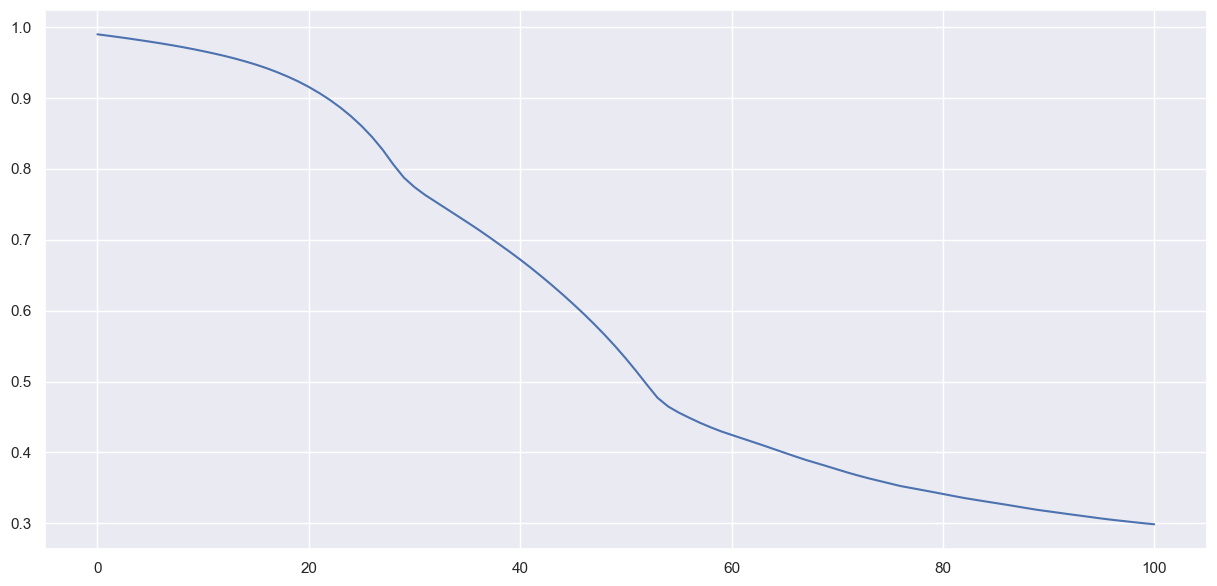

In [16]:
plt.plot(losses)

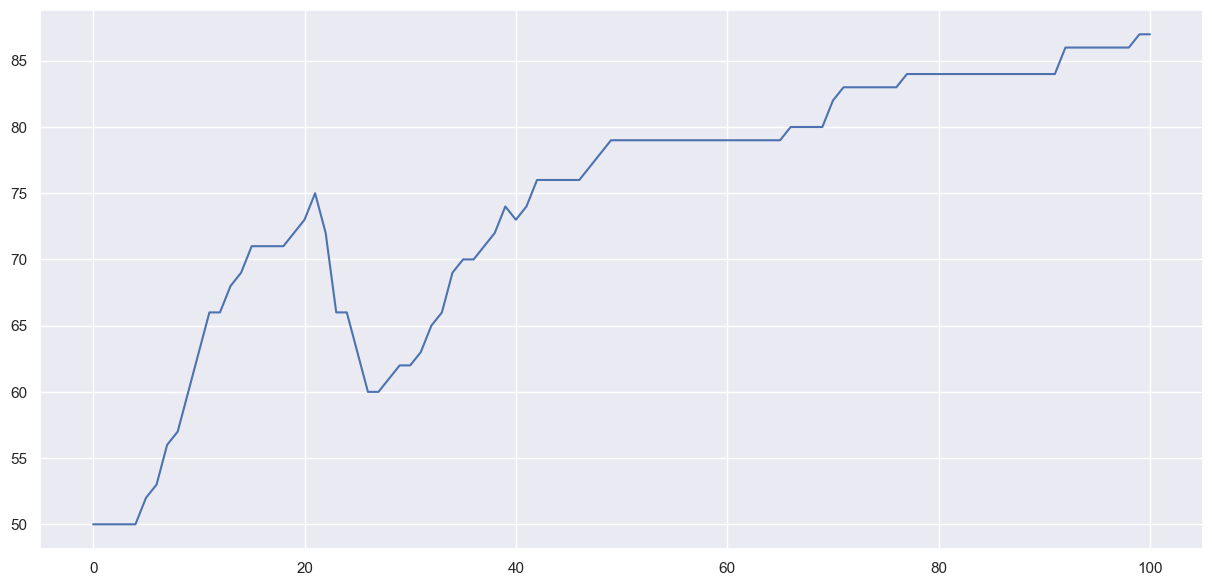

In [17]:
plt.plot(accuracies)

(-1.548639298268643, 1.951360701731357)

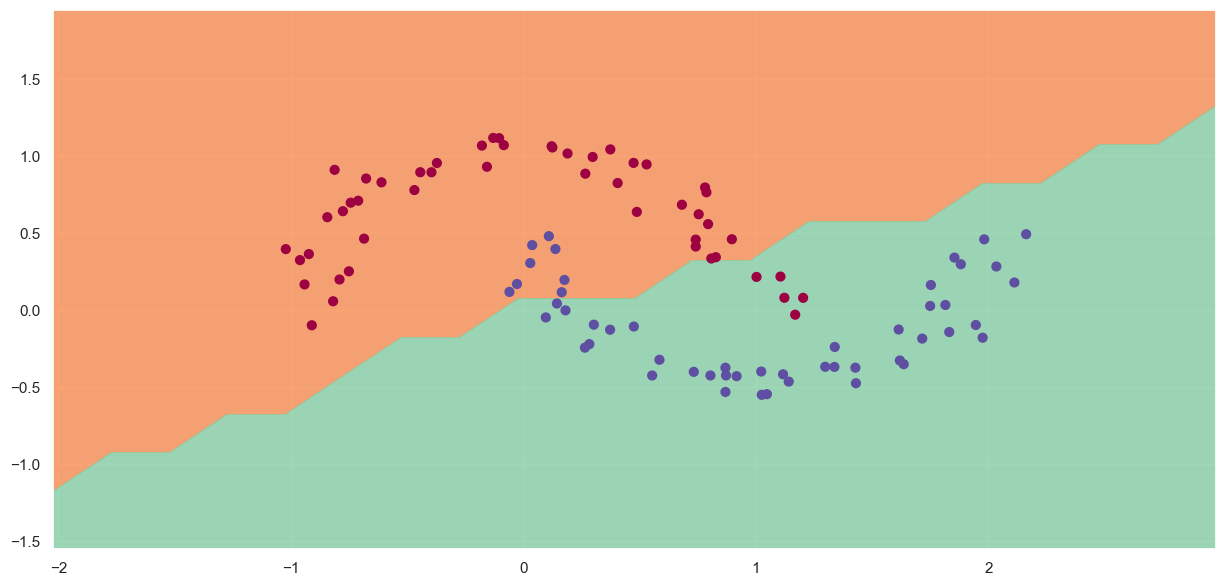

In [18]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = Xmesh

with inference_mode(model):
    scores = model(torch.tensor(inputs, dtype=torch.float))

Z = to_numpy(scores > 0)
Z = Z.reshape(xx.shape)

fig = plt.figure()

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())